In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import warnings
#warnings.filterwarnings("ignore")
#import iris
#from iris import load, Constraint
#import iris.quickplot as qplt
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
#from mpl_toolkits.basemap import Basemap
#from mpl_toolkits import basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
#import xlrd
import os
import matplotlib.colors as colors
#from matplotlib.mlab import bivariate_normal
import seaborn as sns
from ggplot import *

In [89]:
monsoonlist=['NAMS','NAF','SAS','EAS','SAMS','SAF','AUSMC']

In [2]:
 #No change needs here

'''Define CMIP list'''


pmip4=['IPSL-CM6A-LR',
       'HadGEM3-GC31',
       'AWI-ESM']

pmip3=['GISS-E2-1-G',
     'COSMOS-ASO',
     'MRI-CGCM3',
     'CNRM-CM5',
     'FGOALS-g2',
     'GISS-E2-R',
     'EC-EARTH-2-2',
     'IPSL-CM5A-LR',
     'bcc-csm1-1',
     'HadGEM2-CC',
     'HadCM3',
     'MPI-ESM-P',
     'CCSM4',
     'CSIRO-Mk3L-1-2',
     'CSIRO-Mk3-6-0',
     'FGOALS-s2',
     'MIROC-ESM']
pmip_all=['GISS-E2-1-G',
 'COSMOS-ASO',
 'AWI-ESM',
 'MRI-CGCM3',
 'CNRM-CM5',
 'FGOALS-g2',
 'GISS-E2-R',
 'EC-EARTH-2-2',
 'IPSL-CM5A-LR',
 'IPSL-CM6A-LR',
 'bcc-csm1-1',
 'HadGEM3-GC31',
 'HadGEM2-CC',
 'HadCM3',
 'MPI-ESM-P',
 'CCSM4',
 'CSIRO-Mk3L-1-2',
 'CSIRO-Mk3-6-0',
 'FGOALS-s2',
 'MIROC-ESM']

pmip={}
pmip['PMIP3']=pmip3
pmip['PMIP4']=pmip4
pmip['PMIP']=pmip_all

pmip_v4='PMIP4'
pmip_v3='PMIP3'

In [3]:
#No change needs here

'''Define functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
def monsoon_mean(pmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            new_var=this_var.fillna(0)
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(new_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    aaa=average.where(average >2.5)
    ensemble_ave_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_ave_r[r][c]=aaa[r][c-180]          
    return ensemble_ave_r

def monsoon_mean_boundary(pmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in pmip[pmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            new_var=this_var.fillna(0)
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(new_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    aaa=average.where(average >2.5)
    ensemble_ave_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_ave_r[r][c]=aaa[r][c-180]     
    bbb=pd.DataFrame(ensemble_ave_r)
    ccc=np.array(bbb.fillna(3000))
    return ccc

def monsoon_mean_diffence(pmip_v):
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                new_a=expt_a.fillna(0)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                new_b=expt_b.fillna(0)
                diff=new_a-new_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    aaa=average.where(average >2.5)
    ensemble_diff_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            ensemble_diff_r[r][c]=aaa[r][c-180]
    return ensemble_diff_r



y= np.arange(-89.5, 90., 1.0)
x=np.arange(-180, 180., 1.0)

def domain_obs():
    obs_file=xr.open_dataset('data/C20-Reanalysis.cvdp_data.1871-2012.nc',decode_times=False)
    domain=obs_file['monsoon_domain']
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                             'lon': (['lon'], np.arange(0, 360, 1.0))})
    this_regridder=xe.Regridder(obs_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
    obs_domain=this_regridder(domain)
    domain_r=np.zeros((180,360))
    for r in range(180):
        for c in range(360):
            domain_r[r][c]=obs_domain[r][c-180]
    ax=pd.DataFrame(domain_r)
    DO=np.array(ax.fillna(3000))
    return DO


# Figures -- PMIP4 Global monsoon domain

In [31]:
experiment_name='midHolocene'
variable_name='monsoon_domain'
pmip_v='PMIP4'

In [32]:
GMD_mh=monsoon_mean(pmip_v)
GMD_mh_v3=monsoon_mean(pmip_v3)
DO=domain_obs()

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_94x192_180x360_peri.nc


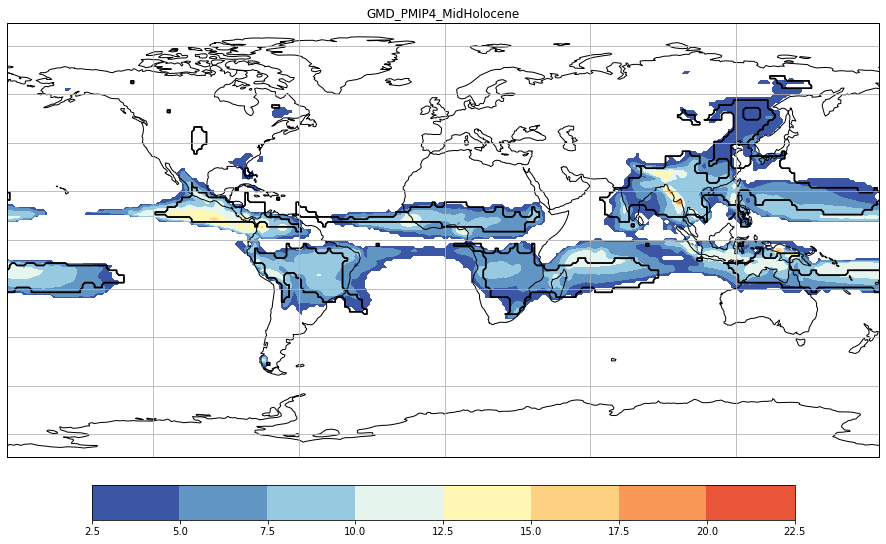

In [39]:
cmap=plt.get_cmap('RdYlBu_r')
clim=[2,25]
bounds = np.linspace(2, 25, 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)




plt.figure(figsize=(18,10))
title='GMD_PMIP4_MidHolocene'
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(title)
ax.coastlines()
ax.gridlines()
fig=ax.contourf(x,y,GMD_mh, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

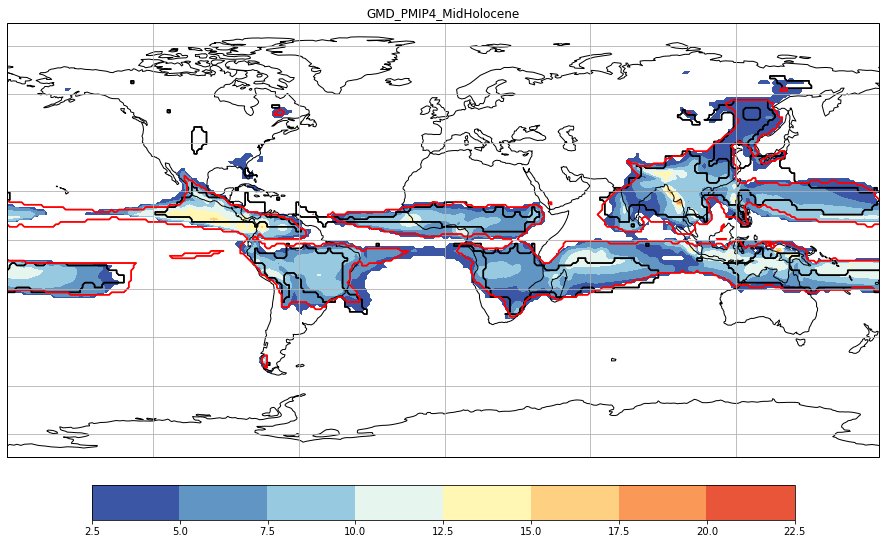

In [39]:
cmap=plt.get_cmap('RdYlBu_r')
clim=[2,25]
bounds = np.linspace(2, 25, 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)




plt.figure(figsize=(18,10))
title='GMD_PMIP4_MidHolocene'
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(title)
ax.coastlines()
ax.gridlines()
fig=ax.contourf(x,y,GMD_mh, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
ax.contour(x,y,GMD_mh_v3, levels=[100,110], colors='r', linestyles='-')
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

In [40]:
experiment_name='piControl'
variable_name='monsoon_domain'

GMD_pi=monsoon_mean(pmip_v)
GMD_pi_v3=monsoon_mean_boundary(pmip_v3)

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Create weight file: bilinear_48x96_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Create weight file: bilinear_73x96_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360

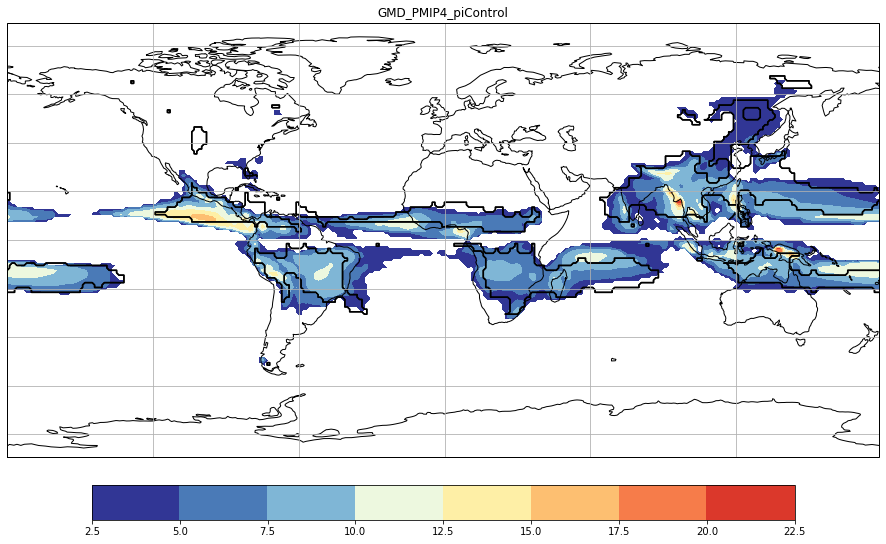

In [34]:
cmap=plt.get_cmap('RdYlBu_r')
clim=[2,25]
bounds = np.linspace(2, 25, 11)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)




plt.figure(figsize=(18,10))
title='GMD_PMIP4_piControl'
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(title)
ax.coastlines()
ax.gridlines()
fig=ax.contourf(x,y,GMD_pi, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

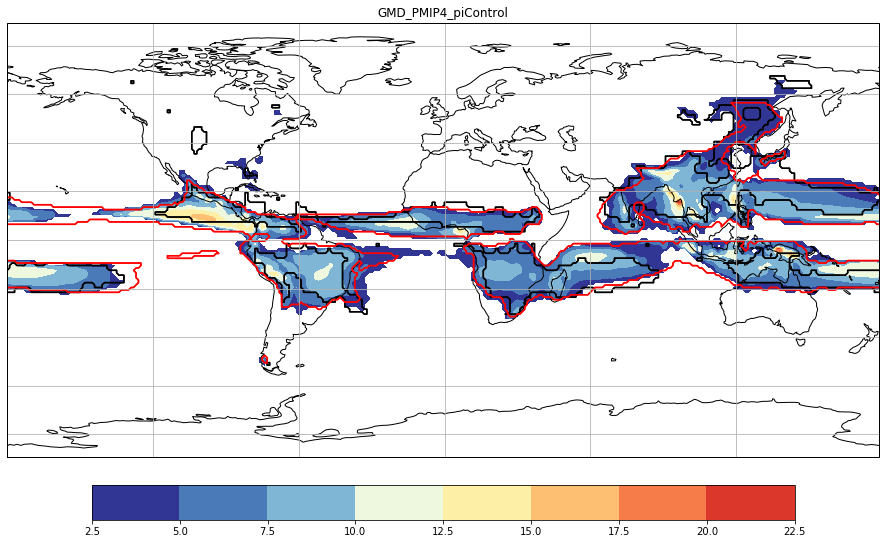

In [47]:


plt.figure(figsize=(18,10))
title='GMD_PMIP4_piControl'
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(title)
ax.coastlines()
ax.gridlines()
fig=ax.contourf(x,y,GMD_pi, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
ax.contour(x,y,GMD_pi_v3, levels=[100,110], colors='r', linestyles='-')
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

In [69]:
experiment_name='midHolocene'
GMD_diff=monsoon_mean_diffence(pmip_v)

Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc


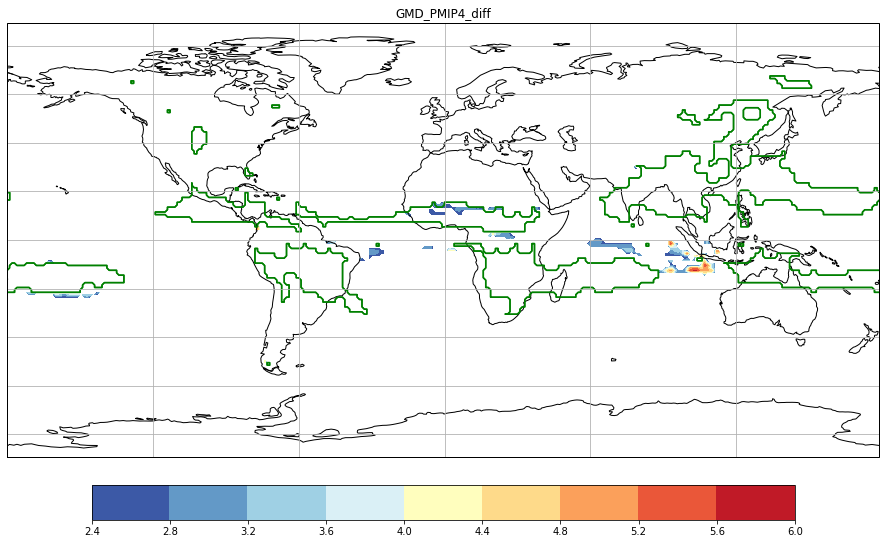

In [73]:
cmap=plt.get_cmap('RdYlBu_r')
#clim=[-10,10]
#bounds = np.linspace(-10, 10, 21)
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)




plt.figure(figsize=(18,10))
title='GMD_PMIP4_diff'
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(title)
ax.coastlines()
ax.gridlines()
fig=ax.contourf(x,y,GMD_diff, transform=ccrs.PlateCarree(),cmap=cmap)#,clim=clim,norm=norm)
ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)




/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1400: UserWarning: The following kwargs were not used by contour: 'clim'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


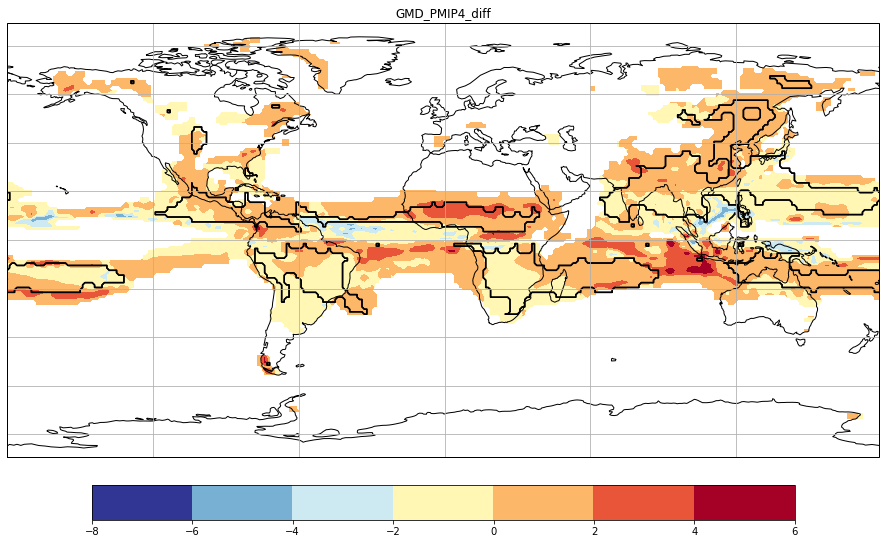

In [67]:
cmap=plt.get_cmap('RdYlBu_r')
clim=[-7.5,5]
bounds = np.linspace(-7.5, 5, 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)




plt.figure(figsize=(18,10))
title='GMD_PMIP4_diff'
ax = plt.axes(projection=ccrs.PlateCarree())
plt.title(title)
ax.coastlines()
ax.gridlines()
fig=ax.contourf(x,y,GMD_diff, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
ax.contour(x,y,DO, levels=[100,110], colors='k', linestyles='-')
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)




# Changes in variables over monsoon domain

In [4]:
def Pav(monsoon_name,experiment_name,pmip_v):
    pav_data=[]
    rainfall_name='monsoon_rain_%s' %monsoon_name
    A_dict=ensemble_members_dict(rainfall_name,experiment_name)
    B_dict=ensemble_members_dict(rainfall_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_rain=expt_a_file[rainfall_name]
                expt_mean_rain=np.nanmean(expt_rain)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_rain=expt_b_file[rainfall_name]
                pi_mean_rain=np.nanmean(pi_rain)
                pav=(expt_mean_rain-pi_mean_rain)*100/pi_mean_rain
                pav_data.append(pav)
    return pav_data


def Psd(monsoon_name,experiment_name,pmip_v):
    psd_data=[]
    rainfall_name='monsoon_rain_%s' %monsoon_name
    A_dict=ensemble_members_dict(rainfall_name,experiment_name)
    B_dict=ensemble_members_dict(rainfall_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_rain=expt_a_file[rainfall_name]
                expt_std_rain=np.nanstd(expt_rain)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_rain=expt_b_file[rainfall_name]
                pi_std_rain=np.nanstd(pi_rain)
                psd=(expt_std_rain-pi_std_rain)*100/pi_std_rain
                psd_data.append(psd)
    return psd_data

In [5]:
def Aav(monsoon_name,experiment_name,pmip_v):
    aav_data=[]
    area_name='monsoon_area_%s' %monsoon_name
    A_dict=ensemble_members_dict(area_name,experiment_name)
    B_dict=ensemble_members_dict(area_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_area=expt_a_file[area_name]
                expt_mean_area=np.nanmean(expt_area)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_area=expt_b_file[area_name]
                pi_mean_area=np.nanmean(pi_area)
                aav=(expt_mean_area-pi_mean_area)*100/pi_mean_area
                aav_data.append(aav)
    return aav_data


def Asd(monsoon_name,experiment_name,pmip_v):
    asd_data=[]
    area_name='monsoon_area_%s' %monsoon_name
    A_dict=ensemble_members_dict(area_name,experiment_name)
    B_dict=ensemble_members_dict(area_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_area=expt_a_file[area_name]
                expt_std_area=np.nanstd(expt_area)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_area=expt_b_file[area_name]
                pi_std_area=np.nanstd(pi_area)
                asd=(expt_std_area-pi_std_area)*100/pi_std_area
                asd_data.append(asd)
    return asd_data

In [67]:
def tot_water(monsoon_name,experiment_name,pmip_v):
    water_data=[]
    area_name='monsoon_area_%s' %monsoon_name
    rainfall_name='monsoon_rain_%s' %monsoon_name
    A_dict=ensemble_members_dict(rainfall_name,experiment_name)
    B_dict=ensemble_members_dict(rainfall_name,'piControl')
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in pmip[pmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_area=expt_a_file[area_name]
                expt_rain=expt_a_file[rainfall_name]
                expt_water=expt_rain*expt_area
                expt_mean_water=np.nanmean(expt_water)
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                pi_rain=expt_b_file[rainfall_name]
                pi_area=expt_b_file[area_name]
                pi_water=pi_rain*pi_area
                pi_mean_water=np.nanmean(pi_water)
                water=(expt_mean_water-pi_mean_water)*100/pi_mean_water
                water_data.append(water)
    return water_data

In [70]:
def df_v(monsoon_name,experiment_name,pmip_v):
    pav_v=Pav(monsoon_name,experiment_name,pmip_v)
    psd_v=Psd(monsoon_name,experiment_name,pmip_v)
    aav_v=Aav(monsoon_name,experiment_name,pmip_v)
    asd_v=Asd(monsoon_name,experiment_name,pmip_v)
    water_v=tot_water(monsoon_name,experiment_name,pmip_v)
    var_pav=[]
    for i in range(len(pav_v)):
        var_pav.append('Pav')
    df_pav=pd.DataFrame({'var':var_pav,pmip_v:pav_v})
    var_psd=[]
    for i in range(len(psd_v)):
        var_psd.append('Psd')
    df_psd=pd.DataFrame({'var':var_psd,pmip_v:psd_v})
    df1=df_pav.append(df_psd)
    var_aav=[]
    for i in range(len(aav_v)):
        var_aav.append('Aav')
    df_aav=pd.DataFrame({'var':var_aav,pmip_v:aav_v})
    df2=df1.append(df_aav)
    var_asd=[]
    for i in range(len(asd_v)):
        var_asd.append('Asd')
    df_asd=pd.DataFrame({'var':var_asd,pmip_v:asd_v})
    df3=df2.append(df_asd)
    var_water=[]
    for i in range(len(water_v)):
        var_water.append('Totwater')
    df_water=pd.DataFrame({'var':var_water,pmip_v:water_v})
    df4=df3.append(df_water)
    return df4



In [95]:
def snsboxplot(monsoon_name,experiment_name):
    df_v3=df_v(monsoon_name,experiment_name,pmip_v3)
    df_v4=df_v(monsoon_name,experiment_name,pmip_v4)
    df=(df_v3.append(df_v4))
    dd=pd.melt(df,id_vars=['var'],value_vars=['PMIP3','PMIP4'],var_name=monsoon_name)
    plt.figure(figsize=(18,10))
    fig=sns.boxplot(x='var',y='value',data=dd,hue=monsoon_name,palette="Set2",linewidth=2.5).set(xlabel='variables', ylabel='change (%)')
    return fig
    


def ggboxplot(monsoon_name,experiment_name):
    df_v3=df_v(monsoon_name,experiment_name,pmip_v3)
    df_v4=df_v(monsoon_name,experiment_name,pmip_v4)
    dd3=pd.melt(df_v3,id_vars=['var'],value_vars=['PMIP3'],var_name='PMIP')
    dd4=pd.melt(df_v4,id_vars=['var'],value_vars=['PMIP4'],var_name='PMIP')  
    p=ggplot(dd3,aes(x='var', y='value',fill='PMIP')) + geom_boxplot(width=0.5)
    s=p+ geom_point(data=dd4,mapping=aes(x='var', y='value'),color='r',size=50)
    return s

In [65]:
monsoon_name='NAF'
experiment_name='midHolocene'

/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


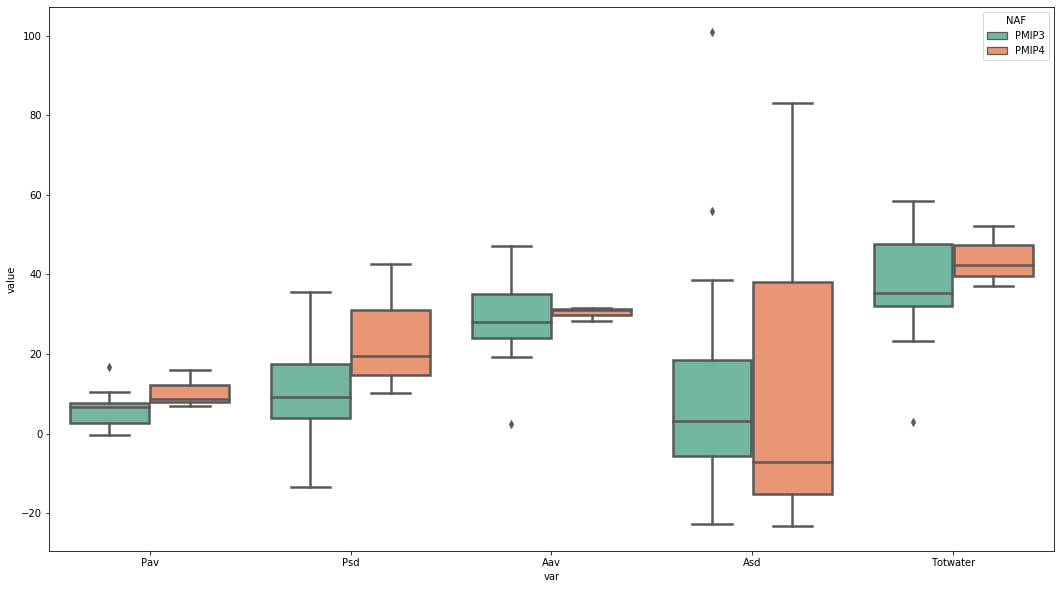

In [88]:
snsboxplot(monsoon_name,experiment_name)

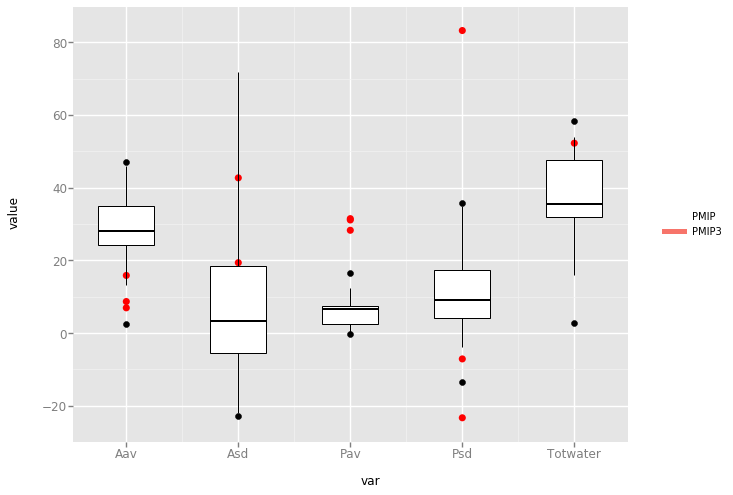

<ggplot: (300089293)>

In [78]:
ggboxplot(monsoon_name,experiment_name)

# midHolocene

/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
/Users/annie/anaconda3/envs/an/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain t

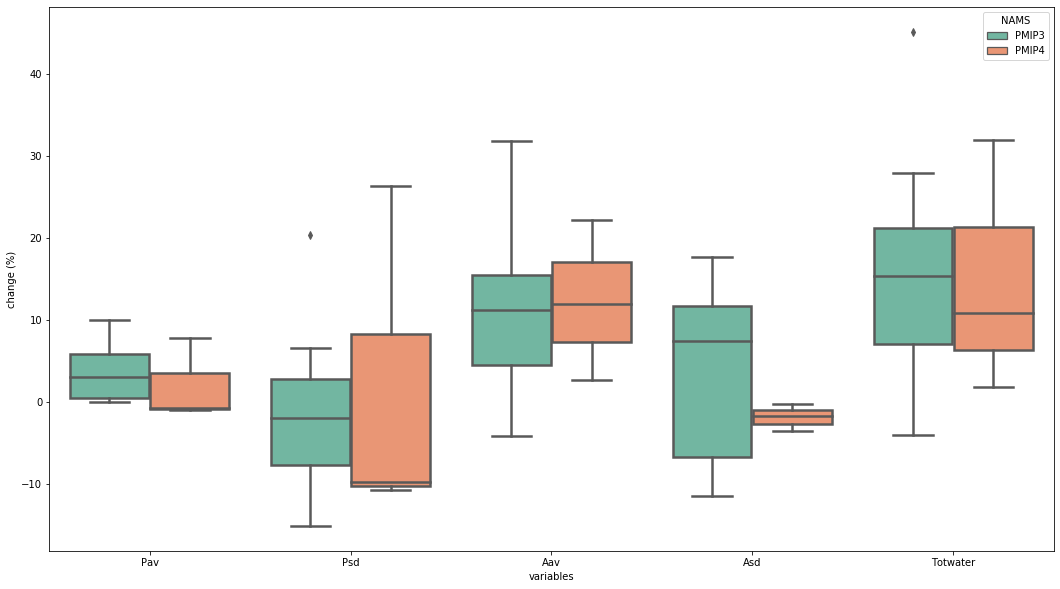

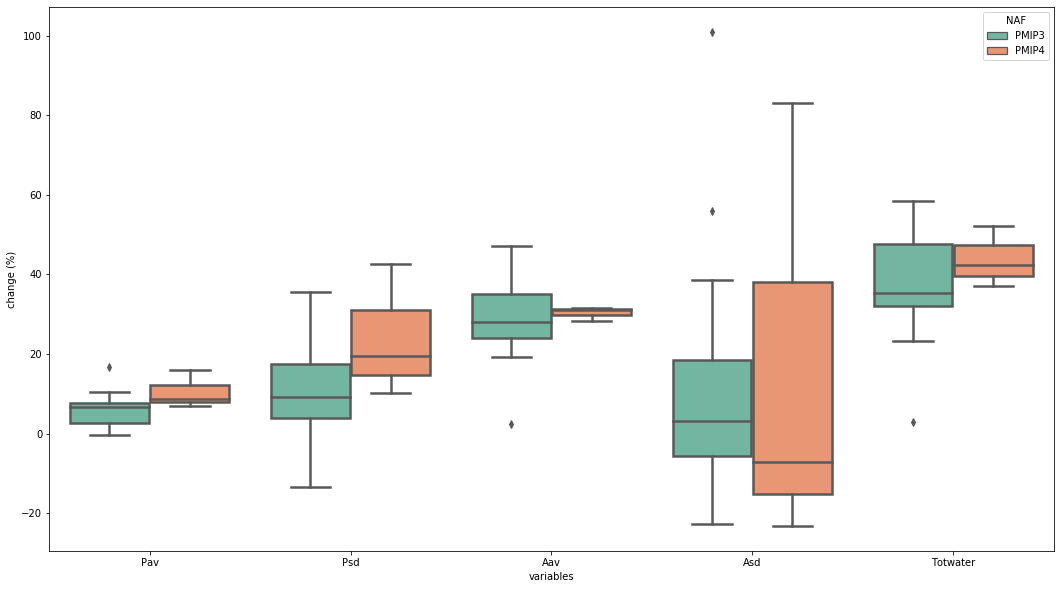

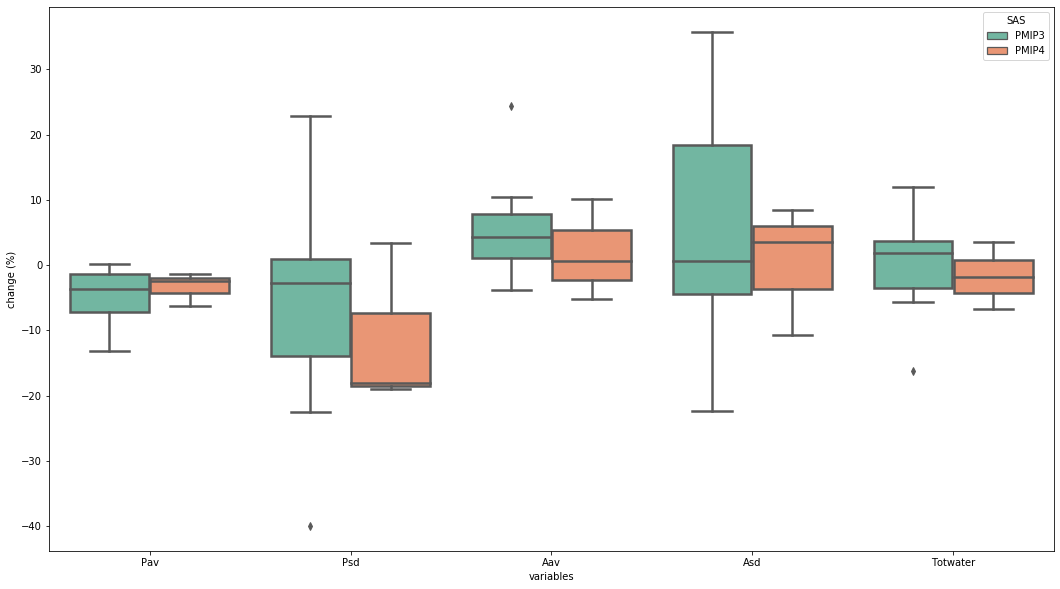

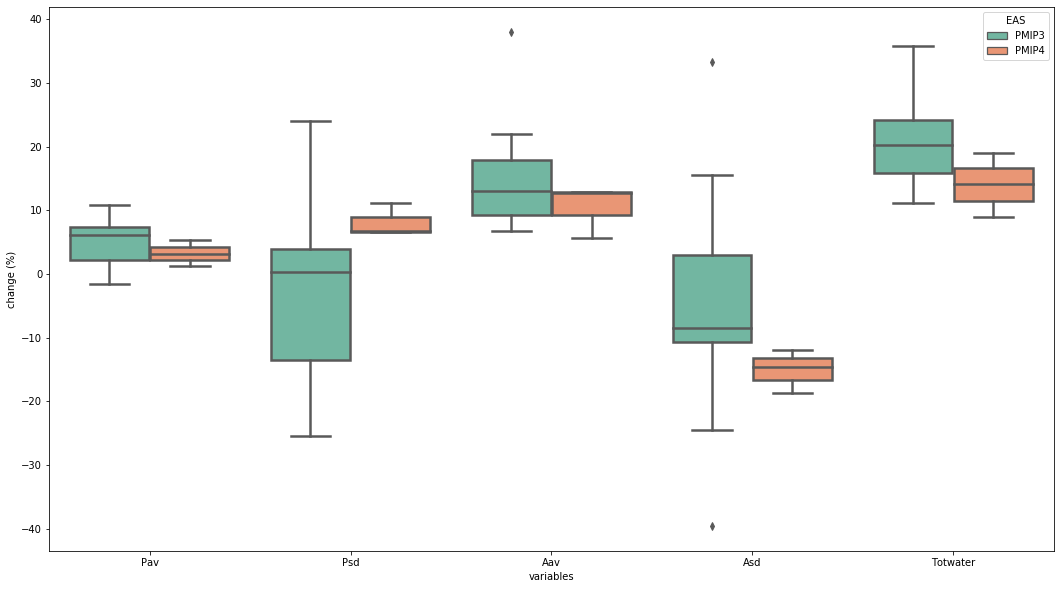

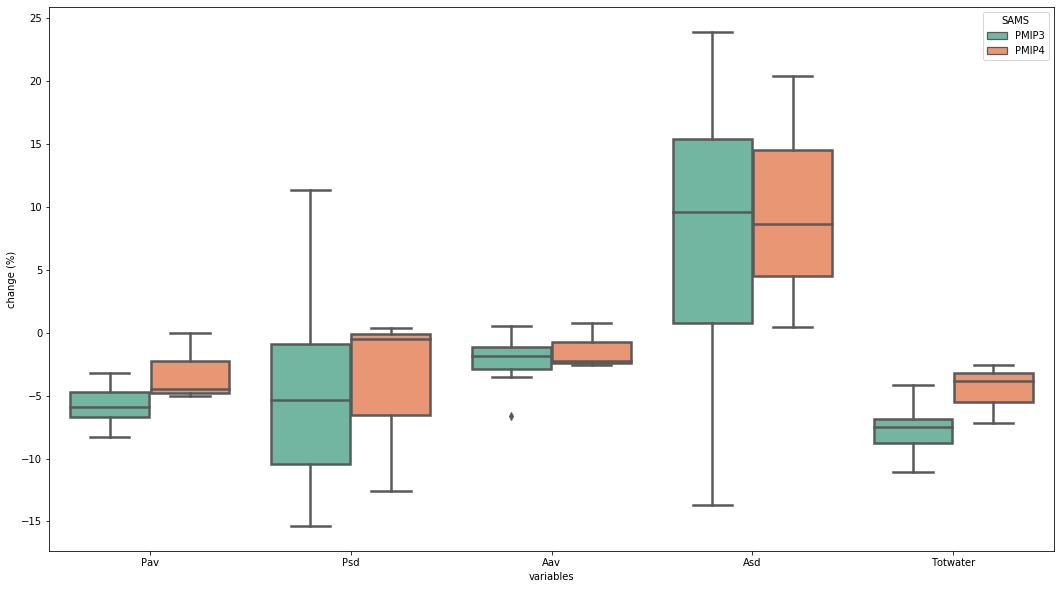

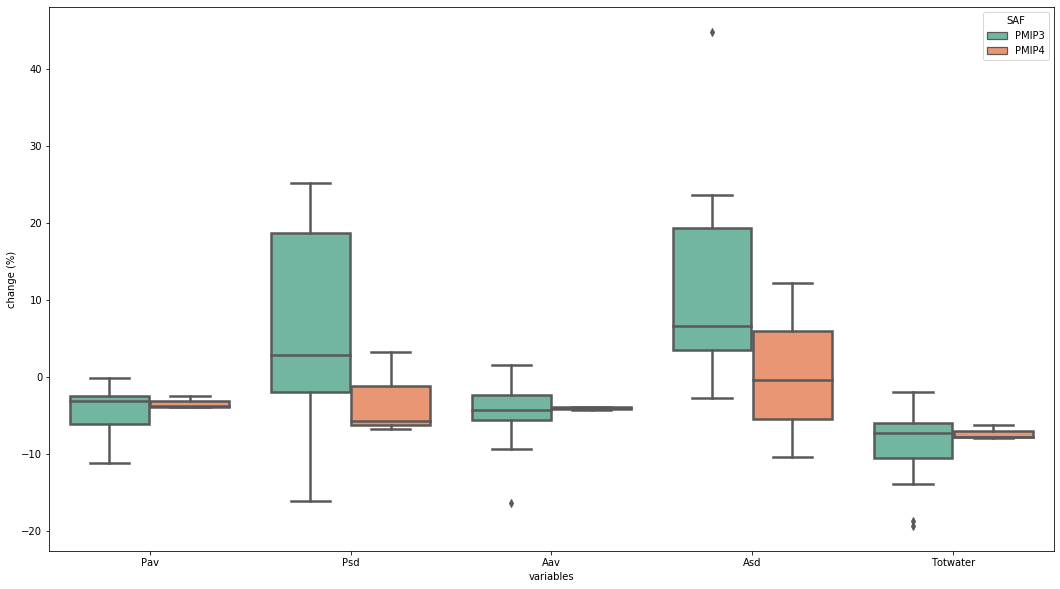

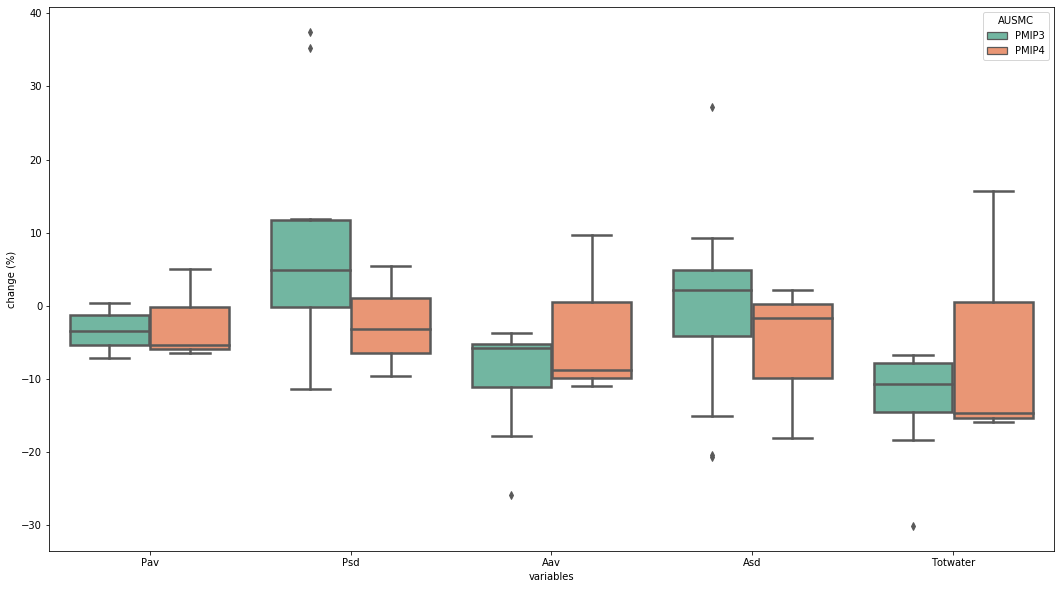

In [97]:
experiment_name='midHolocene'
for m in monsoonlist:
    monsoon_name=m
    snsboxplot(monsoon_name,experiment_name)